In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate
import scipy.ndimage
import scipy.special

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit

In [2]:
# Load the user data
luna_df = pd.read_csv('perceptual_data.csv')
luna_df['nonuniformity'] = (100-luna_df['uniformity'])/(100+luna_df['uniformity'])
luna_df['strongly_worse'] = (luna_df['convresp'] >= 2)
luna_df['any_worse'] = (luna_df['convresp'] >= 1)

In [3]:
# Calculate averages for the different conditions
df = luna_df.copy()

x = {}
y = {}
for crit in ['strongly_worse', 'any_worse']:
    for where in ('nasal', 'temporal'):
        for AR, luning in (('monoar', 'monolune'),
                           ('binoar', 'binolune')):
            df_subset = df.loc[(df['AR'] == AR) &
                               (((df['luning'] == luning) & (df['where'] == where)) |
                               ((df['luning'] == 'nolune') & (pd.isna(df['where']))))]

            x[crit, where, AR], y[crit, where, AR] = [], []
            for n_idx, n in enumerate(sorted(set(df_subset['nonuniformity']))):
                dat = df_subset[df_subset['nonuniformity']==n][crit]
                x[crit, where, AR].append(n)
                y[crit, where, AR].append(dat.mean())

In [4]:
# Gaussian CDF fit, which will be fit to the user data
def cdf_2param(x, mu, sigma):
    return 1/2*(1+math.erf((x-mu)/(sigma*np.sqrt(2))))
cdf_v = np.vectorize(cdf_2param)

# Calculate fits
fits_mean = {}
for crit in ['any_worse', 'strongly_worse']:
    for where in ('nasal', 'temporal'):
        for AR in ('monoar', 'binoar'):
            t = np.linspace(min(x[crit, where, AR]), max(x[crit, where, AR]), 1000)
            fit_params = curve_fit(cdf_v, x[crit, where, AR],
                                          y[crit, where, AR], p0=[0.5, 2])[0]
            fits_mean[crit, where, AR] = fit_params

In [5]:
# Calculate the nonuniformity for a given threshold
def f_nonuniformity(P, mu, sigma):
    return np.sqrt(2)*sigma*scipy.special.erfinv(2*P-1)+mu

target_nonuniformity = lambda crit, where, AR, x, : f_nonuniformity(x, *fits_mean[crit, where, AR])

In [6]:
# Load the eyepiece nonuniformities
eyepiece_csv = pd.read_csv('eyepiece_nonuniformities_without_eyeroll.csv', header=5)

In [7]:
# Add columns with the calculated nonuinformity for the left and right sources
for (idx, row) in eyepiece_csv.iterrows():
    eyepiece_csv.loc[idx, ('source_max')] = np.max([row[f'source_{loc}'] for loc in
                                                   ['center', 'left', 'right']])
    eyepiece_csv.loc[idx, ('source_min')] = np.min([row[f'source_{loc}'] for loc in
                                                   ['center', 'left', 'right']])

eyepiece_csv['nonuniformity_left']  = ((eyepiece_csv['source_max'] - eyepiece_csv['source_left'])/
                                       (eyepiece_csv['source_max'] + eyepiece_csv['source_left']))
eyepiece_csv['nonuniformity_right'] = ((eyepiece_csv['source_max'] - eyepiece_csv['source_right'])/
                                       (eyepiece_csv['source_max'] + eyepiece_csv['source_right']))
eyepiece_csv['nonuniformity_horz']  = ((eyepiece_csv['source_max'] - eyepiece_csv['source_min'])/
                                       (eyepiece_csv['source_max'] + eyepiece_csv['source_min']))
eyepiece_csv['nonuniformity_left'].fillna(0, inplace=True)
eyepiece_csv['nonuniformity_right'].fillna(0, inplace=True)
eyepiece_csv['nonuniformity_horz'].fillna(0, inplace=True)

In [8]:
def rescale_data(eyepiece, data_source=None, scale_data=None):
    if data_source is None:
        data_source = 'nonuniformity'
    if scale_data is None:
        scale_data = 5

    x_orig = eyepiece[['x']].to_numpy().squeeze()
    y_orig = eyepiece[['y']].to_numpy().squeeze()
    z_orig = eyepiece[['z']].to_numpy().squeeze()
    m_orig = eyepiece[[data_source]].to_numpy().squeeze()

    x = np.array(list(sorted(np.unique(x_orig))))
    y = np.array(list(sorted(np.unique(y_orig))))
    z = np.array(list(sorted(np.unique(z_orig))))

    X,Y,Z = np.meshgrid(x, y, z)

    M = scipy.interpolate.griddata((x_orig, y_orig, z_orig), m_orig, (X, Y, Z), method='linear')

    if scale_data:
        M = scipy.ndimage.zoom(M, [scale_data, scale_data, scale_data], output=None, order=3,
                               mode='nearest', prefilter=True)
        x = np.linspace(min(x), max(x), int(len(x)*scale_data))
        y = np.linspace(min(y), max(y), int(len(y)*scale_data))
        z = np.linspace(min(z), max(z), int(len(z)*scale_data))
        
    return [x, y, z, M]

# Calculate the smoothed data
nonuniformity_l = rescale_data(eyepiece_csv, data_source='nonuniformity_left')
nonuniformity_r = rescale_data(eyepiece_csv, data_source='nonuniformity_right')
nonuniformity_h = rescale_data(eyepiece_csv, data_source='nonuniformity_horz')

In [9]:
# Need to flip arrays left/right to account for IPD mismatch direction
nonuniformity_l[3] = np.fliplr(nonuniformity_l[3])
nonuniformity_r[3] = np.fliplr(nonuniformity_r[3])
nonuniformity_h[3] = np.fliplr(nonuniformity_h[3])

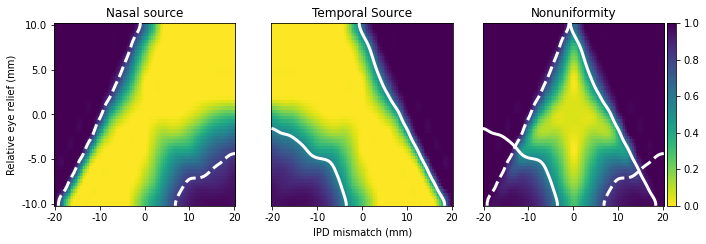

In [10]:
# Plot
idx_x = nonuniformity_h[3].shape[0]//2
thres_p=0.75
    
idx_x = int(idx_x)
data_h = nonuniformity_h[3][idx_x,:,:].copy().T
data_l = nonuniformity_l[3][idx_x,:,:].copy().T
data_r = nonuniformity_r[3][idx_x,:,:].copy().T

data_diff = data_l-data_r

f, axs = plt.subplots(1, 3, figsize=(10, 3.3), dpi=72)
spacing_y = np.mean(np.diff(nonuniformity_h[1]))
spacing_z = np.mean(np.diff(nonuniformity_h[2]))
extent=(min(nonuniformity_h[1])-spacing_y/2, max(nonuniformity_h[1])+spacing_y/2,  # y
        min(nonuniformity_h[2])-spacing_z/2, max(nonuniformity_h[2])+spacing_z/2)  # z

# -------------------------
# Nasal
ax = axs[0]
img = ax.imshow(data_l, interpolation='nearest', origin='lower', vmin=0, vmax=1, extent=extent, zorder=1,
                cmap=plt.get_cmap('viridis_r'))
CS = ax.contour(data_l, [target_nonuniformity('any_worse', 'nasal', 'binoar', thres_p),],
                extent=extent, colors=['w'], linestyles='dashed', zorder=3, linewidths=[3,])
ax.set_title('Nasal source')
ax.set_ylabel('Relative eye relief (mm)')
ax.set_yticks(45.2 + np.linspace(-10, 10, 5))
ax.set_yticklabels(np.linspace(-10, 10, 5))
ax.set_xticks(np.linspace(min(nonuniformity_h[1]), max(nonuniformity_h[1]), 5))
ax.set_xticklabels([f'{i:.0f}' for i in np.linspace(min(nonuniformity_h[1]), max(nonuniformity_h[1]), 5)*2])

# -------------------------
# Temporal
ax = axs[1]
img = ax.imshow(data_r, interpolation='nearest', origin='lower', vmin=0, vmax=1, extent=extent, zorder=1,
                cmap=plt.get_cmap('viridis_r'))
CS = ax.contour(data_r, [target_nonuniformity('any_worse', 'temporal', 'binoar', thres_p),],
                extent=extent, colors=['w'], zorder=3, linewidths=[3,])
ax.set_title('Temporal Source')
ax.set_yticks([])
ax.set_xticks(np.linspace(min(nonuniformity_h[1]), max(nonuniformity_h[1]), 5))
ax.set_xticklabels([f'{i:.0f}' for i in np.linspace(min(nonuniformity_h[1]), max(nonuniformity_h[1]), 5)*2])
ax.set_xlabel('IPD mismatch (mm)')

# -------------------------
# Both
ax = axs[2]
img = ax.imshow(data_h, interpolation='nearest', origin='lower', vmin=0, vmax=1, extent=extent, zorder=1,
                cmap=plt.get_cmap('viridis_r'))
CS = ax.contour(data_l, [target_nonuniformity('any_worse', 'nasal', 'binoar', thres_p),],
                extent=extent, colors=['w'], linestyles='dashed', zorder=3, linewidths=[3,])
CS = ax.contour(data_r, [target_nonuniformity('any_worse', 'temporal', 'binoar', thres_p),],
                extent=extent, colors=['w'], zorder=3, linewidths=[3,])
ax.set_title('Nonuniformity')
ax.set_yticks([])
ax.set_xticks(np.linspace(min(nonuniformity_h[1]), max(nonuniformity_h[1]), 5))
ax.set_xticklabels([f'{i:.0f}' for i in np.linspace(min(nonuniformity_h[1]), max(nonuniformity_h[1]), 5)*2])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img, cax=cax)

plt.tight_layout()
plt.show()